In [26]:
# Cell 1 - Install required packages (run once)
# If you're in local Jupyter you may need to install prophet, matplotlib, and scikit-learn.
# In Colab / some environments use: !pip install prophet
# Uncomment and run if needed.
!pip install prophet matplotlib scikit-learn plotly


Defaulting to user installation because normal site-packages is not writeable


In [27]:
# Cell 2 - Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Prophet import - try both package names to be robust
try:
    from prophet import Prophet
except Exception:
    try:
        from fbprophet import Prophet
    except Exception as e:
        raise ImportError("Prophet not found. Install it with `pip install prophet` or `pip install fbprophet`") from e

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Plot settings
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['font.size'] = 12


In [28]:
import pandas as pd

url = "https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv"
df = pd.read_csv(url, parse_dates=['date'], low_memory=False)


In [29]:
df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN


In [30]:
# Quick glance at columns and sample
df.info(verbose=False)  # just remove null_counts
df[['location','date','total_cases','new_cases','total_deaths']].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Columns: 67 entries, iso_code to excess_mortality_cumulative_per_million
dtypes: datetime64[ns](1), float64(61), int64(1), object(4)
memory usage: 219.5+ MB


,location,date,total_cases,new_cases,total_deaths
0,Afghanistan,2020-01-05,0.0,0.0,0.0
1,Afghanistan,2020-01-06,0.0,0.0,0.0
2,Afghanistan,2020-01-07,0.0,0.0,0.0
3,Afghanistan,2020-01-08,0.0,0.0,0.0
4,Afghanistan,2020-01-09,0.0,0.0,0.0


In [31]:
# Cell 5 - Choose country (or 'World') and create country_df
# Change COUNTRY to any country name present in the dataset (e.g., "India", "United States", "World").
COUNTRY = "India"
country_df = df[df['location'] == COUNTRY].sort_values('date').reset_index(drop=True)
print(f"Selected: {COUNTRY} — rows: {len(country_df)}")
country_df[['date','total_cases','new_cases','total_deaths']].tail(8)


Selected: India — rows: 1682


,date,total_cases,new_cases,total_deaths
1674,2024-08-05,NaN,NaN,NaN
1675,2024-08-06,NaN,NaN,NaN
1676,2024-08-07,NaN,NaN,NaN
1677,2024-08-08,NaN,NaN,NaN
1678,2024-08-09,NaN,NaN,NaN
1679,2024-08-10,NaN,NaN,NaN
1680,2024-08-11,NaN,NaN,NaN
1681,2024-08-12,NaN,NaN,NaN


In [32]:
# Cell 6 - Basic cleaning & feature engineering
# 1) Keep relevant columns
cols = ['date', 'total_cases', 'new_cases', 'total_deaths', 
        'new_deaths', 'total_cases_per_million', 'new_cases_per_million',
        'total_deaths_per_million','people_vaccinated','people_fully_vaccinated']
country_df = country_df[[c for c in cols if c in country_df.columns]].copy()

# 2) Fill missing numeric values sensibly (we'll use forward-fill then 0 as fallback)
country_df.sort_values('date', inplace=True)
country_df.reset_index(drop=True, inplace=True)

# forward fill cumulative columns that should not go down (like total_cases/total_deaths)
for c in ['total_cases','total_deaths','people_vaccinated','people_fully_vaccinated']:
    if c in country_df.columns:
        country_df[c] = country_df[c].ffill().fillna(0)

# For daily new cases/deaths: replace NaN with 0
for c in ['new_cases','new_deaths','new_cases_per_million','total_cases_per_million','total_deaths_per_million']:
    if c in country_df.columns:
        country_df[c] = country_df[c].fillna(0)

# Add moving averages for smoothing and trend
if 'new_cases' in country_df.columns:
    country_df['new_cases_ma7'] = country_df['new_cases'].rolling(window=7, min_periods=1).mean()
    country_df['new_cases_ma14'] = country_df['new_cases'].rolling(window=14, min_periods=1).mean()
if 'new_deaths' in country_df.columns:
    country_df['new_deaths_ma7'] = country_df['new_deaths'].rolling(window=7, min_periods=1).mean()

country_df.tail()


,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,people_vaccinated,people_fully_vaccinated,new_cases_ma7,new_cases_ma14,new_deaths_ma7
1677,2024-08-08,45041748.0,0.0,533623.0,0.0,0.0,0.0,0.0,1.027439e+09,951990535.0,44.714286,39.714286,0.0
1678,2024-08-09,45041748.0,0.0,533623.0,0.0,0.0,0.0,0.0,1.027439e+09,951990537.0,44.714286,39.714286,0.0
1679,2024-08-10,45041748.0,0.0,533623.0,0.0,0.0,0.0,0.0,1.027439e+09,951990545.0,44.714286,39.714286,0.0
1680,2024-08-11,45041748.0,0.0,533623.0,0.0,0.0,0.0,0.0,1.027439e+09,951990547.0,0.000000,22.357143,0.0
1681,2024-08-12,45041748.0,0.0,533623.0,0.0,0.0,0.0,0.0,1.027439e+09,951990552.0,0.000000,22.357143,0.0


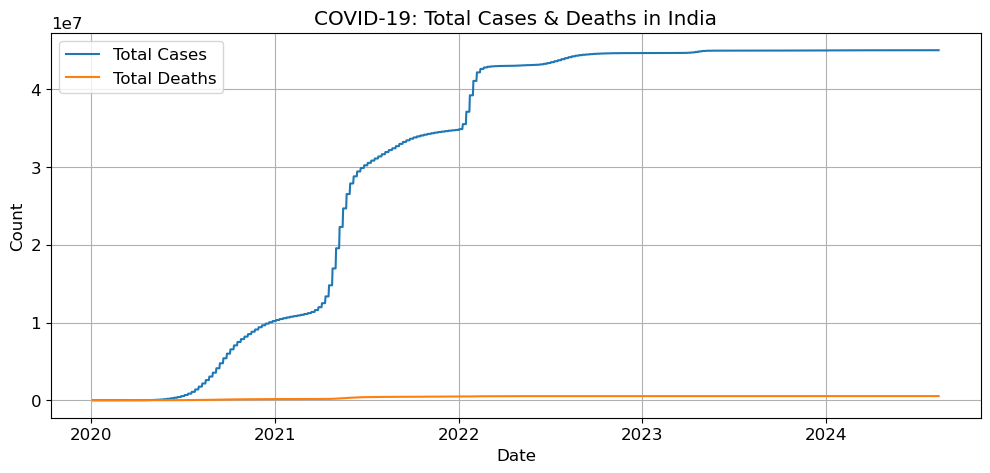

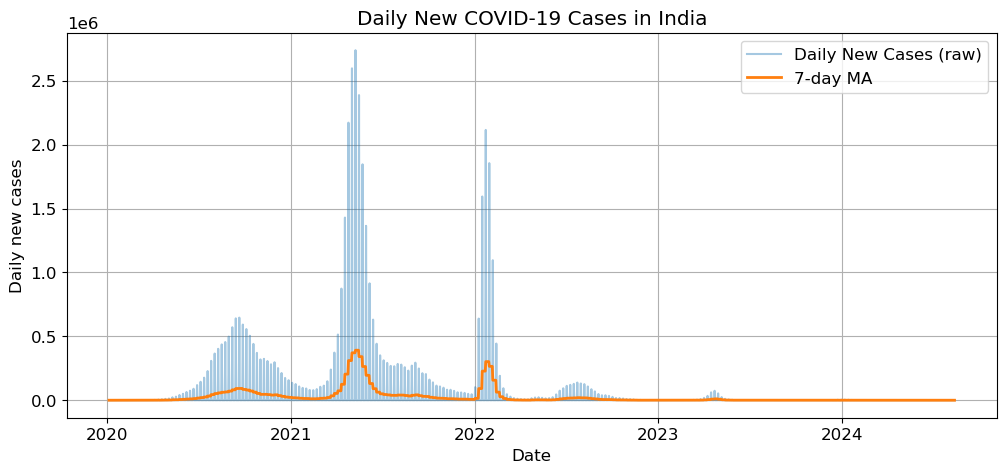

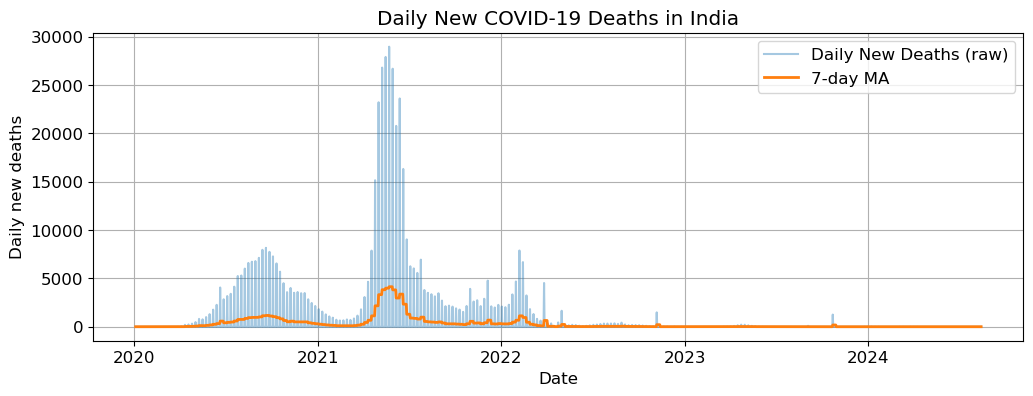

In [33]:
# Cell 7 - Exploratory Data Analysis (plots)
# 7a: Total cases and total deaths over time
plt.figure(figsize=(12,5))
if 'total_cases' in country_df.columns:
    plt.plot(country_df['date'], country_df['total_cases'], label='Total Cases')
if 'total_deaths' in country_df.columns:
    plt.plot(country_df['date'], country_df['total_deaths'], label='Total Deaths')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title(f'COVID-19: Total Cases & Deaths in {COUNTRY}')
plt.legend()
plt.grid(True)
plt.show()

# 7b: Daily new cases (raw and 7-day MA)
plt.figure(figsize=(12,5))
if 'new_cases' in country_df.columns:
    plt.plot(country_df['date'], country_df['new_cases'], alpha=0.4, label='Daily New Cases (raw)')
    plt.plot(country_df['date'], country_df['new_cases_ma7'], label='7-day MA', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Daily new cases')
    plt.title(f'Daily New COVID-19 Cases in {COUNTRY}')
    plt.legend()
    plt.grid(True)
    plt.show()

# 7c: Daily new deaths (raw and 7-day MA)
plt.figure(figsize=(12,4))
if 'new_deaths' in country_df.columns:
    plt.plot(country_df['date'], country_df['new_deaths'], alpha=0.4, label='Daily New Deaths (raw)')
    plt.plot(country_df['date'], country_df['new_deaths_ma7'], label='7-day MA', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Daily new deaths')
    plt.title(f'Daily New COVID-19 Deaths in {COUNTRY}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [34]:
# Cell 8 - Prepare data for Prophet forecasting
# We'll forecast 'new_cases' (daily new cases). Prophet expects columns ds (date) and y (value).
if 'new_cases' not in country_df.columns:
    raise ValueError("new_cases column not found in the selected country data")

prophet_df = country_df[['date','new_cases']].rename(columns={'date':'ds','new_cases':'y'}).copy()

# Prophet expects no missing ds; ensure regular dates exist. If there are missing dates, Prophet can still work
# but it's best to reindex to a continuous date range and fill missing days with 0 new cases (or interpolate).
prophet_df.set_index('ds', inplace=True)
full_index = pd.date_range(start=prophet_df.index.min(), end=prophet_df.index.max(), freq='D')
prophet_df = prophet_df.reindex(full_index).rename_axis('ds').reset_index()
prophet_df['y'] = prophet_df['y'].fillna(0)

prophet_df.tail()


,ds,y
1677,2024-08-08,0.0
1678,2024-08-09,0.0
1679,2024-08-10,0.0
1680,2024-08-11,0.0
1681,2024-08-12,0.0


In [35]:
# Cell 9 - Train/test split for evaluation
# Keep last N days as test (for example 30 days)
TEST_DAYS = 30
train_df = prophet_df.iloc[:-TEST_DAYS].copy()
test_df = prophet_df.iloc[-TEST_DAYS:].copy()

print("Train size:", len(train_df), "Test size:", len(test_df))


Train size: 1652 Test size: 30


In [36]:
# Cell 10 - Fit Prophet model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,  # daily seasonality often too noisy for daily new cases unless you want it
    seasonality_mode='additive'
)
m.add_country_holidays(country_name='IN') if COUNTRY in ['India','United States'] else None  # optional

# Fit (Prophet expects columns ds and y)
m.fit(train_df.rename(columns={'ds':'ds','y':'y'}))

# Make future dataframe (we predict for test period + additional days, e.g., 30 days beyond end)
future_periods = TEST_DAYS + 30  # test stretch and extra forecast horizon
future = m.make_future_dataframe(periods=future_periods, freq='D')
forecast = m.predict(future)


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\holidays\countries\india.py:182: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)
21:51:00 - cmdstanpy - INFO - Chain [1] start processing
21:51:00 - cmdstanpy - INFO - Chain [1] done processing


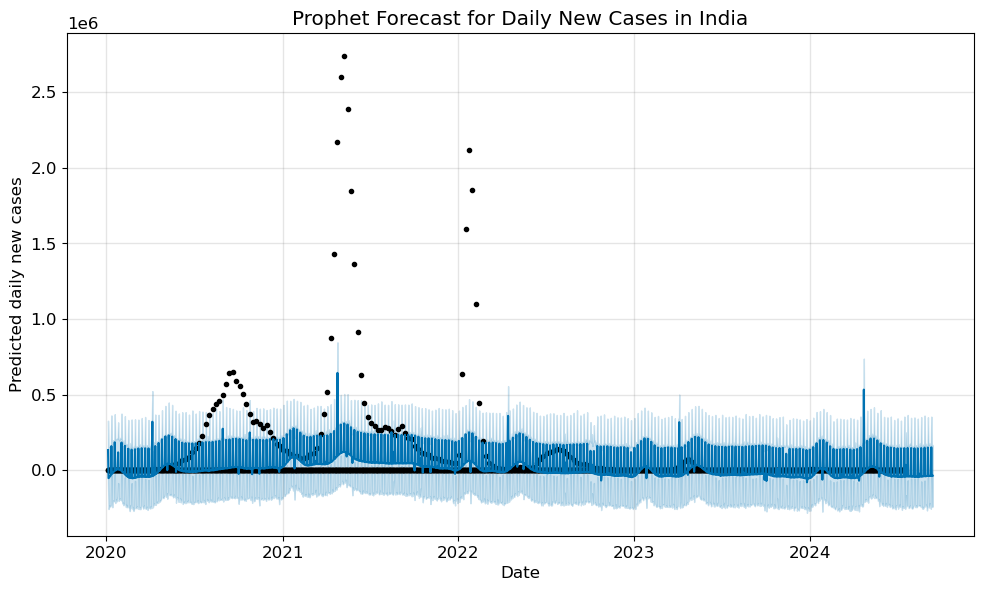

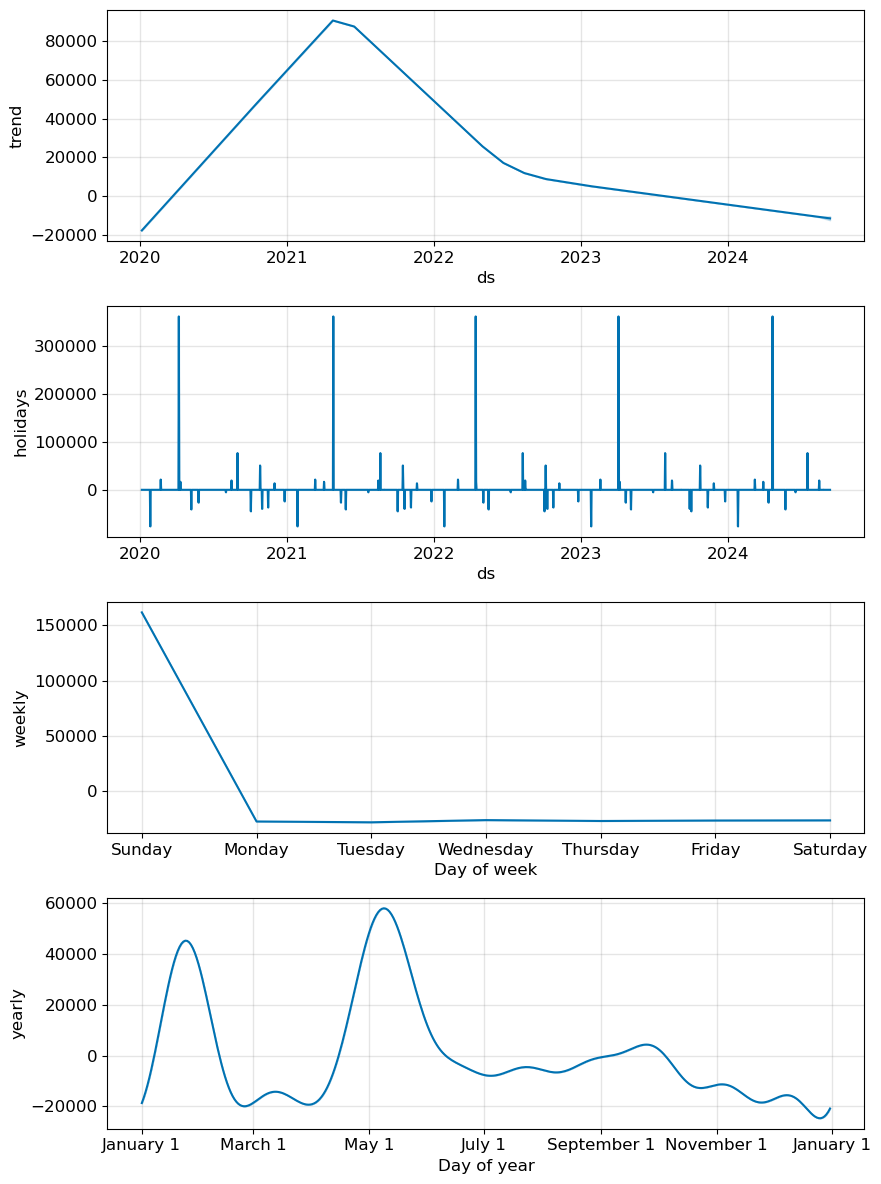

In [37]:
# Cell 11 - Plot forecast (full)
fig1 = m.plot(forecast)
plt.title(f'Prophet Forecast for Daily New Cases in {COUNTRY}')
plt.xlabel('Date')
plt.ylabel('Predicted daily new cases')
plt.show()

# Plot components
fig2 = m.plot_components(forecast)
plt.show()


In [38]:
# Cell 12 - Extract forecast for the test period and compute metrics
# Join forecast with actuals for the overlapping dates
forecast_sub = forecast[['ds','yhat','yhat_lower','yhat_upper']].set_index('ds')
actuals = prophet_df.set_index('ds')['y']

# Select the forecasted values corresponding to the test period
test_index = test_df['ds']
forecast_test = forecast_sub.loc[test_index]

# compute metrics
y_true = actuals.loc[test_index].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

print(f"Evaluation on last {TEST_DAYS} days (test period):")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


Evaluation on last 30 days (test period):
MAE  : 59694.23
RMSE : 70998.55


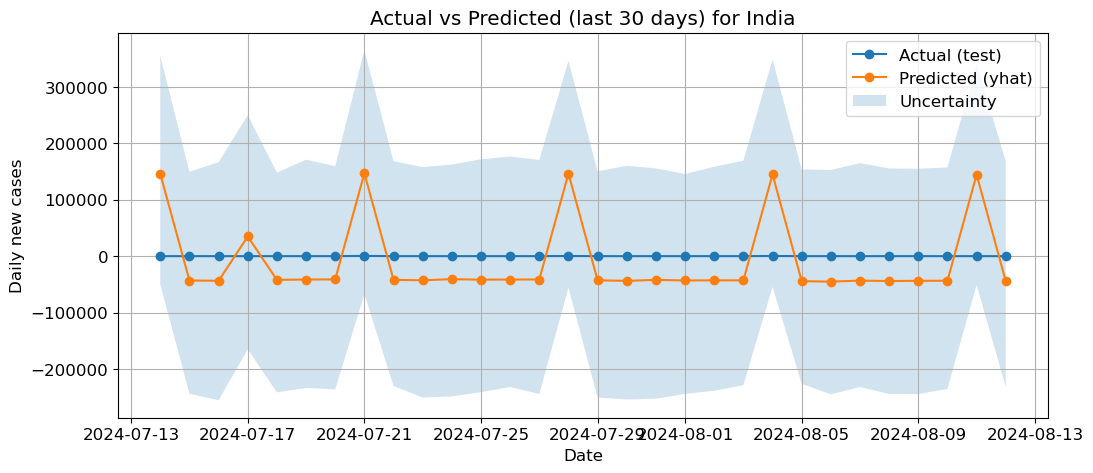

In [39]:
# Cell 13 - Visual comparison: actual vs predicted on test period
plt.figure(figsize=(12,5))
plt.plot(test_index, y_true, label='Actual (test)', marker='o')
plt.plot(test_index, y_pred, label='Predicted (yhat)', marker='o')
plt.fill_between(test_index, forecast_test['yhat_lower'], forecast_test['yhat_upper'], alpha=0.2, label='Uncertainty')
plt.xlabel('Date')
plt.ylabel('Daily new cases')
plt.title(f'Actual vs Predicted (last {TEST_DAYS} days) for {COUNTRY}')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
# Cell 14 - Forecast table for the next 30 days beyond the dataset end
# Find the last date predicted and filter to the future horizon (beyond dataset end)
last_date_in_data = prophet_df['ds'].max()
future_forecast = forecast[forecast['ds'] > last_date_in_data].copy()
future_forecast[['ds','yhat','yhat_lower','yhat_upper']].head(30)

# Optionally save this to CSV
output_csv = f"prophet_forecast_{COUNTRY.replace(' ','_')}.csv"
future_forecast[['ds','yhat','yhat_lower','yhat_upper']].head(30).to_csv(output_csv, index=False)
print("Saved next-30-days forecast to:", output_csv)


Saved next-30-days forecast to: prophet_forecast_India.csv


In [41]:
# Cell 15 - Quick automatic summary (markdown-like print)
print("=== Project Summary ===")
print(f"Country: {COUNTRY}")
print(f"Data range: {prophet_df['ds'].min().date()} to {prophet_df['ds'].max().date()}")
print(f"Model: Prophet (yearly & weekly seasonality)")
print(f"Evaluation (last {TEST_DAYS} days): MAE = {mae:.2f}, RMSE = {rmse:.2f}")
print()
print("Resume line suggestion:")
print("Analyzed global COVID-19 data from Our World in Data to visualize infection and death trends and built a time-series forecasting model using Prophet to predict daily new case counts.")


=== Project Summary ===
Country: India
Data range: 2020-01-05 to 2024-08-12
Model: Prophet (yearly & weekly seasonality)
Evaluation (last 30 days): MAE = 59694.23, RMSE = 70998.55

Resume line suggestion:
Analyzed global COVID-19 data from Our World in Data to visualize infection and death trends and built a time-series forecasting model using Prophet to predict daily new case counts.


In [42]:
# Cell 16 - Optional: Save cleaned country data and forecast for reproducibility
cleaned_csv = f"covid_{COUNTRY.replace(' ','_')}_cleaned.csv"
prophet_df.to_csv(cleaned_csv, index=False)
print("Saved cleaned series to:", cleaned_csv)


Saved cleaned series to: covid_India_cleaned.csv
